# Задание 1

**Задание**

1. Сгенерируйте на плоскости 2 облака точек. Они должны слегка пересекаться, а точки внутри распределены нормально.
2. Обучите линейную модель, разделяющую два облака точек, используя формулу $w = (X^TX)^{-1}X^TY$.
3. Изобразите облака с помощью библиотеки matplotlib, воспользуйтесь функцией scatter, для удобства точки можно сделать прозрачными.
4. Постройте полученнную разделяющую прямую.
5. Оцените сложность алгоритма обучения.

###### 0. Сделаем все необходимые приготовления для начала работы:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

##### 1. Генерируем точки:

Сначала зададим наши два кластера; для этого создадим простой вспомогательный класс `Cluster`, имеющий три интересующие нас характеристики: координаты кластера и среднеквадратическое отклонение.

In [9]:
# === Define clusters ===
class Cluster:
    def __init__(self, x, y, spread):
        self.x = x
        self.y = y
        self.spread = spread

Теперь определим два наугад выбранных кластера (проверено, что они пересекаются)

In [10]:
CLUSTER_SIZE = 500
clusters = [Cluster(0, 0, 1500), Cluster(70, 50, 900)]

Теперь можно и сгенерировать точки. Будем хранить их в виде матрицы размера $\text{CLUSTER_SIZE} \times 3$, где первый столбец заполнен единицами, а второй и третий — $x$- и $y$-координатами соответствующих точек.

In [11]:
NORM = 50                                     # NORM helps make all features ~same magnitude. Otherwise
                                              # there can be problems with gradient

points_to_split = np.concatenate([            # Join the data matrices for all clusters
    np.hstack(                                # Create a matrix of size CLUSTER_SIZE x 3
        (                                     #
            NORM*np.ones((CLUSTER_SIZE, 1)),  # First column --- constant feature of ~same order of magnitude as others
            np.random.multivariate_normal(    # Second and third --- random numbers,
                [c.x, c.y],                   # centered on clusters (x, y) coordinates
                c.spread*np.identity(2),      # with cluster's spread.
                CLUSTER_SIZE                  # There will be CLUSTER_SIZE such points
            )
        )
    ) for c in clusters                       # Do for all (both) clusters
])

Раз уж мы здесь, сгенерируем и эталонные результаты классификации. Тут всё тривиально — по `CLUSTER_SIZE` единиц и минус единиц.

In [12]:
true_labels = np.vstack((
    1*np.ones((CLUSTER_SIZE, 1)),
    -1*np.ones((CLUSTER_SIZE, 1))
))

##### 2. Обучаем модель

Обучение тоже довольно прямолинейно: просто воспользуемся данной нам свыше формулой  $w = (X^TX)^{-1}X^TY$:

In [13]:
split_vector_exact = np.linalg.inv(points_to_split.T.dot(points_to_split)).dot(points_to_split.T).dot(true_labels)

Осталось понять, как трактовать этот вектор.

Минутка теории; пусть $m-1$ --- число фич, $n$ --- число объектов. Тогда заметим, что `split_vector_exact` представляет собой $(M_{m\times n} \times M_{n\times m})^{-1}\times M_{m \times n} \times M_{n \times 1} = M_{m\times m}^{-1}\times M_{m \times 1} = M_{m\times 1}$, то есть, в нашем случае, вектор размерности 3. Три его координаты задают плоскость в трёхмерном пространстве, а именно:

$$
z = w_0*\mathrm{NORM} + w_1x + w_2y.
$$

Так как нас интересует прямая $z = 0$, легко решить уравнение и получить

$$
y = -\frac{w_0*\mathrm{NORM} + w_1x}{w_2}.
$$

Построим эту прямую:

In [14]:
x_points = np.linspace(-200, 200, 2)
splitting_line_y = np.array((-split_vector_exact[0]*NORM - split_vector_exact[1]*x_points)/split_vector_exact[2])

##### 3 + 4. Построение:

Построение — не самая увлекательная часть работы, но самая зрелищная. Для начала сделаем несколько приготовлений и настроек:

In [15]:
plt.switch_backend('nbAgg')                                  # Plot in Jupyter Notebook
cluster_split_figure = plt.figure(figsize=(12, 8))
split_plot = cluster_split_figure.add_subplot(111)

split_plot.axis([-200, 200, -150, 200])                      # Set axis size
cluster_split_figure.gca().set_aspect('equal')               # and aspect ratio

color_dict = {'red':   [(0.0, 0.0, 0.0),
                        (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0),
                        (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 1.0, 1.0),
                        (1.0, 0.0, 0.0)]}

color_map = matplotlib.colors.LinearSegmentedColormap('Map', color_dict)  # Create color map for clusters

А теперь построим наши точки и полученную разделяющую прямую:

<IPython.core.display.Javascript object>


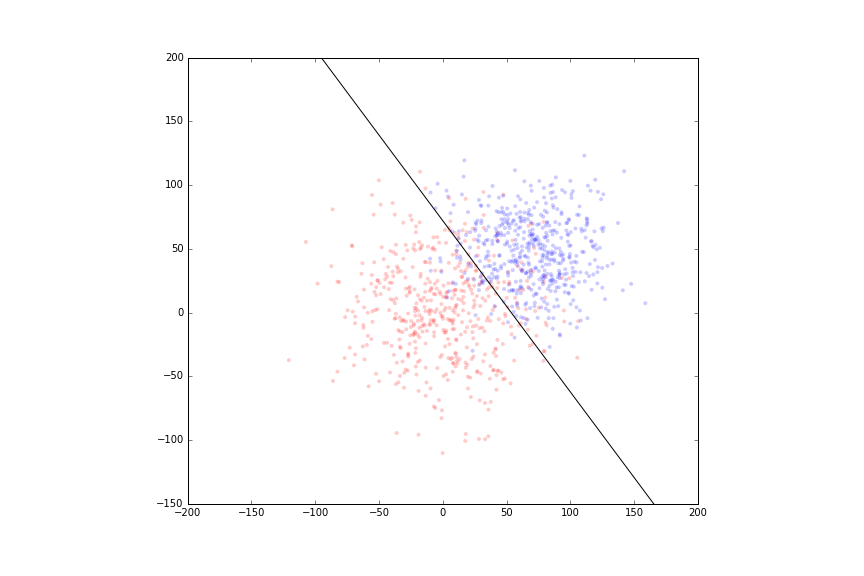

In [16]:
split_plot.scatter(
    points_to_split[:, 1],
    points_to_split[:, 2],
    marker='.',
    s=64,
    c=true_labels.T,
    cmap=color_map,
    edgecolors='none',
    alpha=0.2,
)

split_plot.plot(x_points, splitting_line_y, color='black', linewidth=1)  # Plot the dividing line

cluster_split_figure.show()

И вправду похоже на хорошее разделение!

##### 5. Оценка сложности

(здесь и далее `CLUSTER_SIZE` будет обозначен через $N$)

Очевидно, что всё обучение заключено в этой строке:

`split_vector_exact = np.linalg.inv(points_to_split.T.dot(points_to_split)).dot(points_to_split.T).dot(true_results)`.

К сожалению, при существовании оптимизированных алгоритмов умножения квадратных матриц, умножение неквадратных матриц $M_{p\times q} \times M_{q\times r}$ всё ещё занимает $\mathcal{O}(pqr)$. Однако, это упрощает оценку сложности:

Вспомним указанную выше "формулу": 

$$
    w \approx (M_{m\times n} \times M_{n\times m})^{-1}\times M_{m \times N} \times M_{N \times 1}
$$

Распишем произведения и их сложности:

$$
    (\underbrace{M_{m\times n} \times M_{n\times m}}_{\mathcal{O}(m\cdot n \cdot m) = \mathcal{O}(m^2n)})^{-1}\times \underbrace{M_{m \times n} \times M_{n \times 1}}_{\mathcal{O}(m\cdot n \cdot 1) = \mathcal{O}(mn)} \to
    \underbrace{(M_{m\times m})^{-1}}_{\mathcal{O}(m^3)}\times M_{m \times 1} \to
    \underbrace{M_{m\times m}\times M_{m \times 1}}_{\mathcal{O}(m^2)} \to M_{3 \times 1}
$$

Итого $\mathcal{O}(m^2n+mn+m^3+m^2) = \mathcal{O}\left(m^2(n+m)\right)$.

# Задание 2

**Задание**

1. Пусть $\mathbb{P}\{y=1|x\} = \sigma(wx+b)$, где $\sigma(z) = \frac{1}{1 + \exp(-z)}$. Покажите, что задача
$$ \mathop{\mathrm{argmin}}\limits_{w, b} \sum\limits_{x, y} \ln(1 + \exp(-y(wx + b)))$$
есть не что иное, как максимизация правдоподобия.
2. Отобразите все функционалы качества в осях $M \times Q$ для одного элемента.

##### 2. Сравнение функционалов качества

Для начала выразим $Q$ через $M$ для всех наших функционалов:

1. Квадратичная ошибка:

    $$Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}((wx_i+b) - y_i)^{2}$$
    
    Так как мы рассматриваем только один элемент, $l = 1$ и формула выглядит так:
    
    $$Q(w) = ((wx+b) - y)^{2} = \left(\frac{(wx+b)y}{y} - y\right)^2 = \left(\frac{M}{y} - y\right)^2$$
    
    Заметим, что при $y = \pm 1$, выражение не меняется, т.к. $\frac{M}{1} - 1 = -1\cdot\left(\frac{M}{-1} + 1\right)$, значит, модули и квадраты выражений совпадают. Тогда
    
    $$Q(M) = (M - 1)^2$$
2. SVM

    $$Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \max(0, 1 - y_i\cdot(wx_i + b))$$
    
    Опять же, в нашем случае формула будет выглядеть так:
    
    $$Q(w) = \max(0, 1 - y\cdot(wx + b)) = \max(0, 1 - M)$$
    
3. Логистическая функция

    $$ Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \ln(1 + \exp(-y_i\cdot(wx_i + b)))$$
    
    В нашем случае:
    
    $$ Q(w) = \ln(1 + \exp(-y\cdot(wx + b))) = \ln(1 + \exp(-M))$$

Теперь оформим их в виде функций:

In [17]:
def loss_wrong(margin):
    return margin < 0

def loss_square(margin):
    return (margin-1)**2

def loss_svm (margin):
    return np.maximum(0, 1-margin)

def loss_logistic(margin):
    return np.log(1+np.exp(-margin))

И построим графики:

<IPython.core.display.Javascript object>


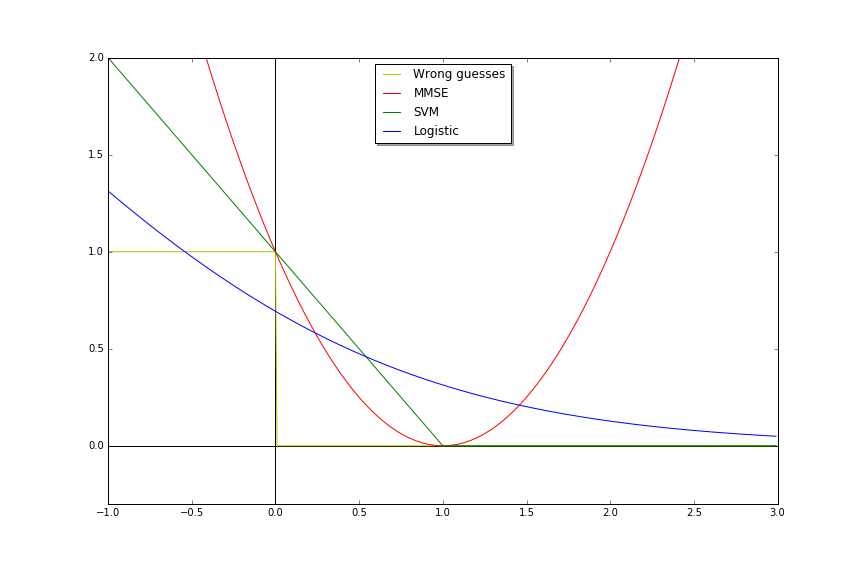

In [18]:
loss_func_figure = plt.figure(figsize=(12, 8))
loss_func_plot = loss_func_figure.add_subplot(111)

loss_func_plot.axis([-1, 3, -0.3, 2])
loss_func_plot.axhline(0, color='black')
loss_func_plot.axvline(0, color='black')

t = np.arange(-3, 3, 0.01)

loss_func_plot.plot(t, loss_wrong(t)   , c='Y', label='Wrong guesses')
loss_func_plot.plot(t, loss_square(t)  , c='r', label='MMSE')
loss_func_plot.plot(t, loss_svm(t)     , c='g', label='SVM')
loss_func_plot.plot(t, loss_logistic(t), c='b', label='Logistic')

legend = plt.legend(loc='upper center', shadow=True)
loss_func_figure.show()

# Задание 3

**Задание**
1. Предложите какую-нибудь квадратичную функцию с глобальным минимумом.
2. Найдите минимум методом градиентного спуска.
3. Отобразите на плоскости линии уровней функции, которую вы оптимизируете.
4. Покажите, какую траекторию проходит алгоритм градиентного спуска.
5. Как вы выбрали значение $\eta$?

Выберем какую-нибудь простую функцию; например,

$$f(x, y) = 2(x-5)^2 + (y+3)^2$$

с градиентом

$$\begin{pmatrix}
    4(x-5)\\
    2(y+3)
\end{pmatrix}.$$

В Python это будет выглядеть так:

In [19]:
def func(x):
    return 2*(x[0]-5)**2 + (x[1]+3)**2
def func_grad(x):
    return np.array([
        4*(x[0]-5),
        2*(x[1]+3)
    ])

Напишем базовую функцию градиентного спуска с ограниченным числом шагов:

In [20]:
def fixed_gradient_descent(grad, learning_rate, steps, start_point):
    curr_point = start_point
    interm_sequence = [start_point]
    
    for iter in range(steps):
        curr_point = curr_point - learning_rate*grad(curr_point)
        interm_sequence.append(curr_point)

    return np.array(interm_sequence)

Попробуем найти минимум нашей функции с помощью градиентного спуска:

In [21]:
trajectory = fixed_gradient_descent(
    func_grad,
    1e-2,
    100,
    np.multiply(np.random.random_sample(2), np.array([20, 25]))-np.array([5, 15])  # Get random point in plotted area
)

И построим траекторию движения:

<IPython.core.display.Javascript object>


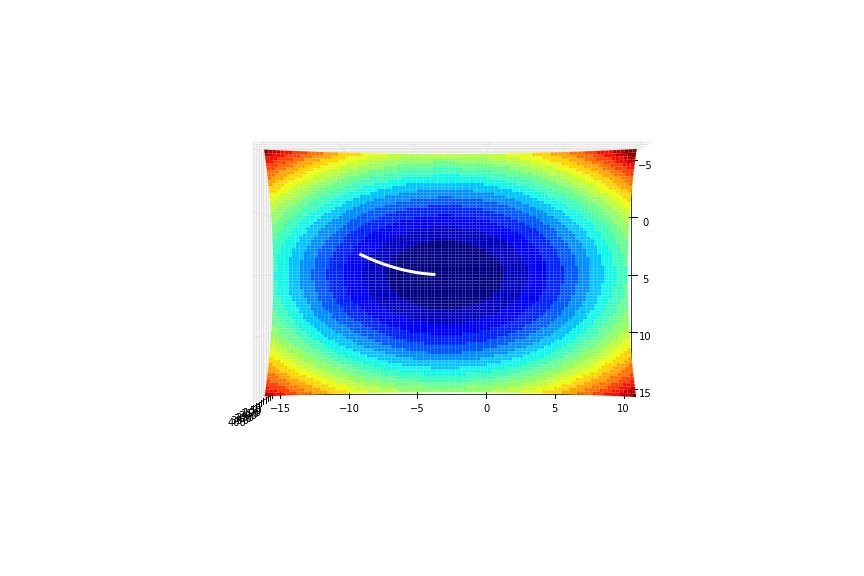

In [22]:
# === Plot settings ===
square_figure = plt.figure(figsize=(12, 8))
square_plot = square_figure.gca(projection='3d')

X = np.arange(-5, 15, 0.25)
Y = np.arange(-15, 10, 0.25)
square_plot.axis([-5, 15, -15, 10])
X, Y = np.meshgrid(X, Y)
square_plot.view_init(90, 0)

# === Plot ===
square_plot.plot_surface(
    X,
    Y,
    func([X, Y]),
    rstride=1,
    cstride=1,
    cmap=cm.get_cmap('jet', 20),
    linewidth=0,
    antialiased=True
)

square_plot.plot(
    trajectory[:, 0],
    trajectory[:, 1],
    np.array([
        func(point) for point in trajectory
    ]),
    color='white',
    linewidth=3
)

square_figure.show()

(а ещё график трёхмерный!)

При этом $\eta$ была выбрана почти наугад, методом проб и ошибок; понятно, что слишком большой её делать нет смысла, потому что мы начнём "раскачиваться" в бесконечность (легко показать, что при $\eta \geqslant 0.5$ мы окажемся не ближе к минимуму, чем начинали); а такого значения хватает, чтобы довольно быстро сходиться и не иметь проблем (по крайней мере, на этой конкретной функции). При этом интервал допустимых значений $\eta$ относительно большой и подобрать "хорошее" значение несложно и без дополнительных ухищрений.

# Задание 4

**Задание**
1. Проделайте все то же самое для функции Розенброка.
2. Какую проблему вы наблюдаете?
3. Как ее можно решить?

А теперь функция Розенброка; её градиент равен

$$
\begin{pmatrix}
    2(x-1) + 400(x^3 - xy)\\
    200(y-x^2)
\end{pmatrix}
$$

In [16]:
def rosenbrock(x):
    return (1-x[0])**2 + 100*(x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    return np.array([
        2*(x[0]-1) + 400*(-x[1]*x[0] + x[0]**3),
        200*(x[1]-x[0]**2)
    ])

Посмотрим, насколько хорошо работает наш "глупый" градиентный спуск:

In [17]:
rosenbrock_trajectory = fixed_gradient_descent(
    rosenbrock_grad,
    0.03,
    100,
    np.multiply(np.random.rand(2), np.array([20, 25]))-np.array([5, 15])
)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


Хм. Что-то не так. Посмотрим на траекторию:

In [18]:
print(rosenbrock_trajectory[:10])

[[  8.90968280e+000   9.86007713e-001]
 [ -8.37341385e+003   4.71364647e+002]
 [  7.04508108e+012   4.20682001e+008]
 [ -4.19603627e+039   2.97799005e+026]
 [  8.86541249e+119   1.05640322e+080]
 [             -inf   4.71573232e+240]
 [              nan               inf]
 [              nan               nan]
 [              nan               nan]
 [              nan               nan]]


Расходимся. Попробуем константу поменьше --- тогда же должны получиться хорошие шаги?

In [19]:
rosenbrock_trajectory = fixed_gradient_descent(
    rosenbrock_grad,
    0.003,
    100,
    np.multiply(np.random.rand(2), np.array([20, 25]))-np.array([5, 15])
)

print(rosenbrock_trajectory[:10])

[[  4.69309491e+000   7.38496590e+000]
 [ -7.77783349e+001   1.61690703e+001]
 [  5.63034757e+005   3.63614926e+003]
 [ -2.14183917e+017   1.90204884e+011]
 [  1.17907605e+052   2.75248502e+034]
 [ -1.96701059e+156   8.34132198e+103]
 [              inf               inf]
 [              nan               nan]
 [              nan               nan]
 [              nan               nan]]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


А если стартовую область поменьше сделаем, чтобы градиент был чуть более разумным по величине?

In [20]:
rosenbrock_trajectory = fixed_gradient_descent(
    rosenbrock_grad,
    0.003,
    100,
    np.random.rand(2) # Get random point in [-1,1]x[-1,1]
)

print(rosenbrock_trajectory[-10:])

[[ 0.40199621  0.15866849]
 [ 0.40416962  0.16042796]
 [ 0.40632591  0.16218304]
 [ 0.40846531  0.16393366]
 [ 0.41058803  0.16567981]
 [ 0.41269432  0.16742144]
 [ 0.41478437  0.16915854]
 [ 0.41685842  0.17089106]
 [ 0.41891667  0.17261899]
 [ 0.42095932  0.1743423 ]]


А теперь не успели сойтись. Больше итераций?

In [21]:
rosenbrock_trajectory = fixed_gradient_descent(
    rosenbrock_grad,
    0.003,
    100000,
    np.random.rand(2) # Get random point in plotted area
)

print(rosenbrock_trajectory[-10:])

[[ 0.78595562  0.56687171]
 [ 0.73927661  0.59738442]
 [ 0.78595562  0.56687171]
 [ 0.73927661  0.59738442]
 [ 0.78595562  0.56687171]
 [ 0.73927661  0.59738442]
 [ 0.78595562  0.56687171]
 [ 0.73927661  0.59738442]
 [ 0.78595562  0.56687171]
 [ 0.73927661  0.59738442]]


Не получается. Тонкое дело, явно сложнее нашей квадратичной функции. А почему так?

##### 2-3. Функция Розенброка

Построим график этой функции и посмотрим, где могут возникать проблемные места:

<IPython.core.display.Javascript object>


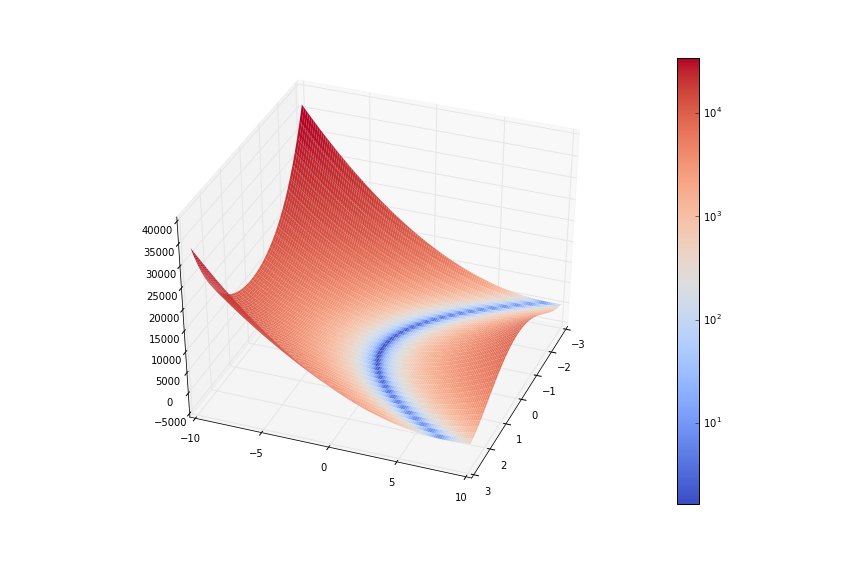

In [38]:
rosenbrock_figure = plt.figure(figsize=(12, 8))
rosenbrock_plot = rosenbrock_figure.gca(projection='3d')
X = np.arange(-3, 3, 0.15)
Y = np.arange(-10, 10, 0.15)
X, Y = np.meshgrid(X, Y)
rosenbrock_plot.view_init(38, 21)

R = (1-X**2)+100*(Y-X**2)**2
rosenbrock_surface = rosenbrock_plot.plot_surface(
    X,
    Y,
    R,
    rstride=1,
    cstride=1,
    norm=matplotlib.colors.LogNorm(),
    cmap=cm.coolwarm,
    linewidth=0,
    antialiased=True
)

rosenbrock_figure.colorbar(rosenbrock_surface)

rosenbrock_figure.show()

Заметим, что у неё есть параболическая почти ровная долина, где градиент почти равен нулю — попав в неё мы к минимуму в $(1, 1)$ будем сходиться очень медленно (да ещё и продолжая покачиваться --- градиент же не направлен ровно вдоль параболы); в остальных же точках, как легко заметить, функция растёт очень быстро, и градиент (в зависимости от $\eta$, конечно) скорее всего "перепрыгнет" долину и окажется на другой стороне. При этом, (опять же, в зависимости от $\eta$), начиная, грубо говоря, с какого-то расстояния от долины, мы после прыжка окажемся дальше от долины, чем начинали, и будем дальше прыгать, раскачиваясь всё дальше и уходя в бесконечность. Таким образом, область, где мы можем стартовать и хотя бы оказаться в долине, очень невелика; увеличить мы её можем, уменьшая $\eta$, но тут возникает другая проблема — чем меньше $\eta$, тем меньше шаги и тем дольше мы будем перемещаться по и без того очень пологой долине. Так что нужно правильно подбирать $\eta$, сохраняя баланс, а ещё лучше — варьировать по необходимости. Идеально — выбрать такую $\eta_1$, чтобы первым же шагом оказаться в долине; после этого шансов выпрыгнуть из неё и уйти в бесконечность будет гораздо меньше и можно использовать какую-то разумную $\eta$, даже, возможно, и константную, для следующих шагов и сойтись.

# Задание 5

**Задание**
1. Снова разделите облака точек, только теперь оптимизируйте квадратичную ошибку методом градиентного спуска.
2. Отобразите полученную прямую и облака точек.
3. Сравните ответ с точным решением.
4. Попробуйте метод наискорейшего спуска.
5. Постройте график в осях (номер шага и значение $Q$).
6. Сравните скорость сходимости обычного и наискорейшего спуска.

Давайте снова воспользуемся уже сгенерированным набором точек. Как и раньше, будем считать, что у нас нет $b$, зато каждый $x$ имеет дополнительную координату, равную 1; тогда $b = w^{(0)}$.

Найдём частные производные нашей $Q$:

$$Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}(wx_i - y_i)^{2}$$

$$
\frac{d}{d w^{(j)}} Q(w) =
\frac{d}{d w^{(j)}}\left(\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}(wx_i - y_i)^{2}\right) =
\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}\frac{d}{d w^{(j)}}\left(\sum\limits_{k=1}^3 w^{(k)}x_i^{(k)}- y_i\right)^{2} =
\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}2x_i^{(j)}\left(\sum\limits_{k=1}^3 w^{(k)}x_i^{(k)}- y_i\right) =
\frac{2}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}}x_i^{(j)}\left(wx_i- y_i\right)
$$

Двойку можно игнорировать (читай "внести в $\eta$"). Тогда искомый градиент на Python выглядит так:

In [23]:
def mean_squared_error(candidate_vector, points, labels):
    return 1/labels.size*sum((points[i].dot(candidate_vector)-labels[i])**2 for i in range(labels.size))

def mean_squared_error_grad(candidate_vector, points, labels):
    return np.array([
            1 / (np.size(points, axis=0)) * sum(
                (points[i].dot(candidate_vector)-labels[i]).item()*points.item((i, j))
                for i in range(np.size(points, axis=0))
            )
            for j in range(np.size(points, axis=1))
        ])

Ну и сама оптимизация:

In [36]:
random_start_point = np.multiply(np.random.random_sample(3), np.array([100, 100, 100]))

split_vector_grad_trajectory = fixed_gradient_descent(
    lambda w: mean_squared_error_grad(w, points_to_split, true_labels),
    0.0001,
    100,
    random_start_point
)

split_vector_grad = split_vector_grad_trajectory[-1]

x_points = np.linspace(-200, 200, 2)
splitting_line_grad_y = np.array((-split_vector_grad[0]*NORM - split_vector_grad[1]*x_points)/split_vector_grad[2])

И снова построим точки, но на этот раз с двумя разделяющими прямыми:

<IPython.core.display.Javascript object>


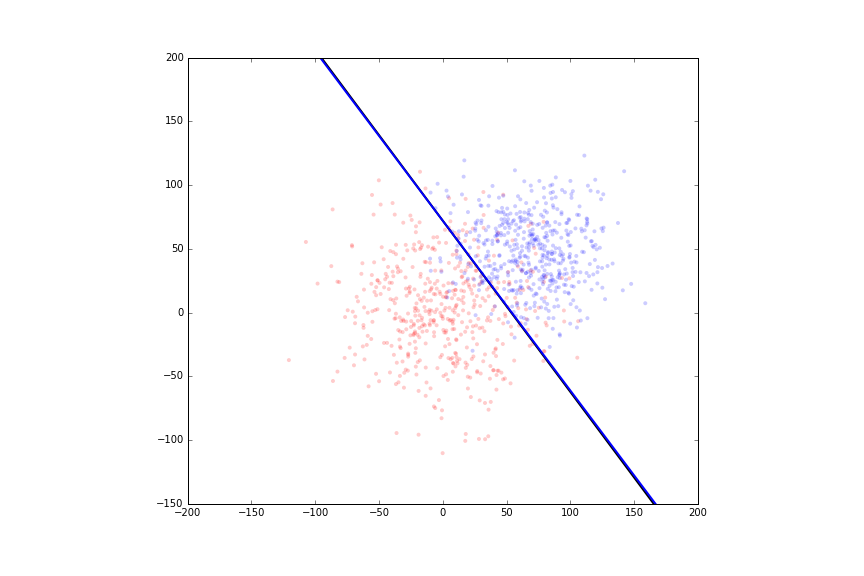

In [37]:
grad_comp_figure = plt.figure(figsize=(12, 8))
grad_comp_plot = grad_comp_figure.add_subplot(111)

grad_comp_plot.axis([-200, 200, -150, 200])
grad_comp_figure.gca().set_aspect('equal')

grad_comp_plot.scatter(
    points_to_split[:, 1],
    points_to_split[:, 2],
    
    marker='.',
    s=64,
    c=true_labels.T,
    cmap=color_map,
    edgecolors='none',
    alpha=0.2,
)

grad_comp_plot.plot(x_points, splitting_line_y, color='black', linewidth=2)  # Plot the dividing line
grad_comp_plot.plot(x_points, splitting_line_grad_y, color='blue', linewidth=2)  # Plot the dividing line

grad_comp_figure.show()

Даже разницы почти не видно! Действительно, давайте рассмотрим полученные векторы:

In [26]:
print(split_vector_grad)
print(split_vector_exact[:,0])

[ 0.01248665 -0.01124607 -0.00880009]
[ 0.01240329 -0.01125986 -0.00869602]


Почти идеальное совпадение!

##### Метод наискорейшего спуска

По сути, мы хотим перемещаться вдоль антиградиента не на некоторое заранее заданное расстояние, а в ту точку на луче, где значение нашей функции минимально; воспользуемся для этого `scipy.optimize`:

In [43]:
from scipy.optimize import minimize

def steepest_gradient_descent(grad, func, steps, start_point):
    curr_point = start_point
    interm_sequence = [start_point]
    
    for iter in range(steps):
        curr_learn_rate = minimize(lambda dist: func(curr_point-dist*grad(curr_point)), np.zeros((1, 1))).x[0]

        curr_point = curr_point - curr_learn_rate*grad(curr_point)
        interm_sequence.append(curr_point)

    return np.array(interm_sequence)

И проверим, как он работает:

In [44]:
split_vector_steepest_grad_trajectory = steepest_gradient_descent(
    lambda w: mean_squared_error_grad(w, points_to_split, true_labels),
    lambda x: mean_squared_error(x, points_to_split, true_labels),
    10,
    random_start_point
)

split_vector_steepest_grad = split_vector_steepest_grad_trajectory[-1]

In [45]:
splitting_line_steepest_grad_y = np.array(
    (-split_vector_steepest_grad[0]*NORM - split_vector_steepest_grad[1]*x_points)/split_vector_steepest_grad[2]
)

<IPython.core.display.Javascript object>


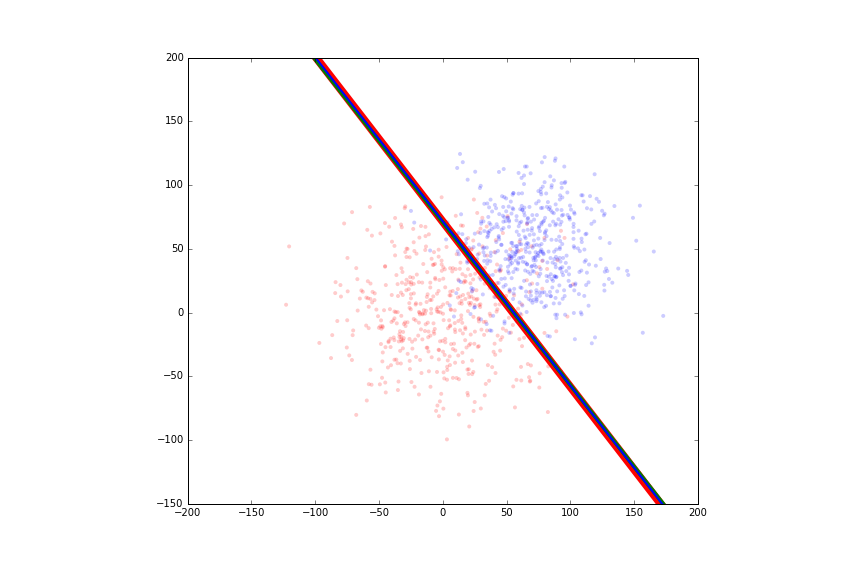

In [46]:
grad_comp_2_figure = plt.figure(figsize=(12, 8))
grad_comp_2_plot = grad_comp_2_figure.add_subplot(111)

grad_comp_2_plot.axis([-200, 200, -150, 200])
grad_comp_2_figure.gca().set_aspect('equal')

grad_comp_2_plot.scatter(
    points_to_split[:, 1],
    points_to_split[:, 2],
    
    marker='.',
    s=64,
    c=true_labels.T,
    cmap=color_map,
    edgecolors='none',
    alpha=0.2,
)

grad_comp_2_plot.plot(x_points, splitting_line_y, color='red', linewidth=8)
grad_comp_2_plot.plot(x_points, splitting_line_grad_y, color='green', linewidth=4)
grad_comp_2_plot.plot(x_points, splitting_line_steepest_grad_y, color='blue', linewidth=2)

grad_comp_2_figure.show()

И снова совпадает, что, впрочем, не очень удивительно. Давайте теперь сравним скорость схождения:

<IPython.core.display.Javascript object>


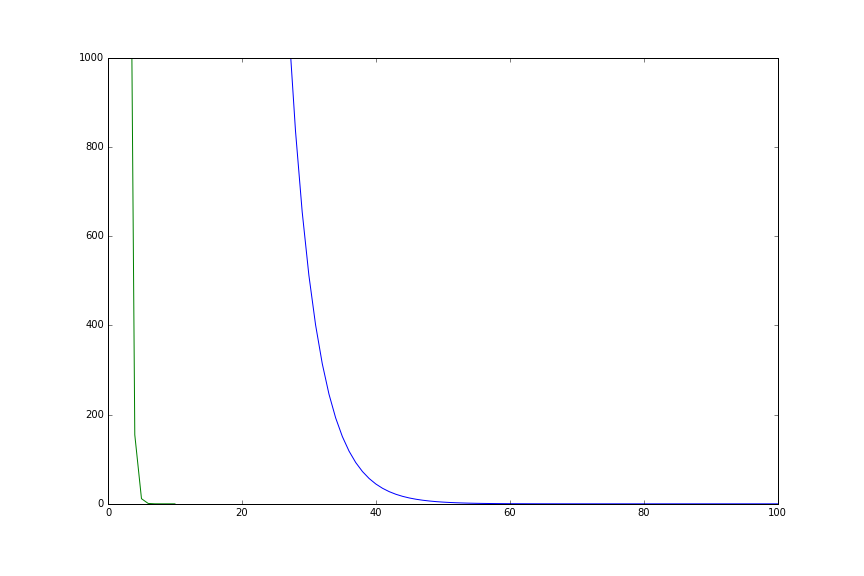

In [55]:
grad_comp_rate_figure = plt.figure(figsize=(12, 8))
grad_comp_rate_plot = grad_comp_rate_figure.add_subplot(111)

grad_comp_rate_plot.axis([0, 100, 0, 1000])

grad_comp_rate_plot.plot(
    np.arange(0, 101),
    np.array(list(map(
        lambda w: mean_squared_error(w, points_to_split, true_labels).item(),
        split_vector_grad_trajectory
    )))
)

grad_comp_rate_plot.plot(
    np.arange(split_vector_steepest_grad_trajectory.shape[0]),
    np.array(list(map(
        lambda w: mean_squared_error(w, points_to_split, true_labels).item(),
        split_vector_steepest_grad_trajectory
    )))
)

grad_comp_rate_figure.show()

И вправду наискорейший. Легко видеть, что такая модификация ускоряет схождение алгоритма на порядки; оно и неудивительно — в отличие от обычного градиентного спуска, где мы выбираем $\eta$ фактически с помощью, так сказать, educated guess, тут каждый шаг гарантированно даёт нам лучший из всех возможных результатов.

##### Задание 6

Проблема разреженности фичи (и, более обще, малого среднего значения фичи по сравнению с другими) в том, что частная производная по этой фиче тоже в среднем будет меньше производных по другим фичам; это приводит к тому, что, так как остальные фичи "перевешивают", даже в случае наискорейшего спуска мы будем по этому признаку сходиться гораздо медленнее прочих, так как $\eta$ у всех частных производных одна. Эта более медленная сходимость ничем не компенсируется, и, вероятнее всего, по этому признаку мы и не сойдёмся, либо потратим гораздо (**гораздо**) больше шагов. В частности, я на это наткнулся, когда изначально не ввёл `NORM` и первый признак был равен 1, тогда как прочие измерялись десятками и сотнями. Это приводило к тому, что разделяющая прямая была параллельна искомой, но, так как $b$ не сходилось, она была проведена совершенно не там, где нужно.

# 5. Стохастический градиентный спуск

**Задание**

1. Скачайте данные mnist c [Kaggle](https://www.kaggle.com/c/digit-recognizer).
2. Обучите линейный классификатор 0 и 1, используйте логистическую функцию потерь.
3. Проверьте качество классификации на отложенной выборке.
$$ \mathcal{L}(y_{pred}, y_{true}) = [y_{pred} \neq y_{true}]$$
4. Как влияет размер батча на скорость и качество обучения?
5. Отобразите графики, которые доказывает ваши слова (оси придумайте сами).
6. Сколько проходов по данным вы делаете? Почему?

Для начала стоит найти градиент нашей функции, то есть частные производные:

$$Q(w) = \frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \ln(1 + \exp(-y_i\cdot wx_i))$$

$$
\frac{d}{dw^{(j)}}Q(w) =
\frac{d}{dw^{(j)}}\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \ln(1 + \exp(-y_i\cdot wx_i)) = 
\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \frac{d}{dw^{(j)}} \ln(1 + \exp(-y_i\cdot wx_i)) =\\=
\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \left(
\frac{1}{1 + \exp(-y_i\cdot wx_i)}
\cdot \left(\frac{d}{dw^{(j)}} \exp(-y_i\cdot wx_i)\right)\right)
=
\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \left(
\frac{1}{1 + \exp(-y_i\cdot wx_i)}
\cdot \left(\exp(-y_i\cdot wx_i)\cdot\left(\frac{d}{dw^{(j)}}\left(-y_i\cdot wx_i \right)\right)\right)
\right)=\\=
\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \left(
\frac{1}{1 + \exp(-y_i\cdot wx_i)}
\cdot \left(\exp(-y_i\cdot wx_i)\cdot\left(
-y_ix_i^{(j)}\right)\right)
\right)=\\=
\frac{1}{\mathcal{l}} \sum_{i=1}^{\mathcal{l}} \left(
\frac{\exp(-y_i\cdot wx_i)\cdot
(-y_ix_i^{(j)})}{1 + \exp(-y_i\cdot wx_i)}
\right)
$$

Теперь реализуем функцию и градиент:

In [149]:
def logistic_loss(w, points, labels):
    return 1/labels.size * sum(
        np.log(1 + np.exp(-labels[i]*(w.dot(points[i]))))
        for i in range(labels.size)
    )

def logistic_loss_grad(w, points, labels):
    return np.reshape(np.array([
        1/labels.size * sum(
            np.exp(-labels[i]*w.dot(points[i]))*(-labels[i]*points[i, j])/(1+np.exp(-labels[i]*w.dot(points[i])))
            for i in range(points.shape[0])
        )
        for j in range(w.size)
    ]), (points.shape[1],))

Поработаем с MNIST. Для начала подготовим данные для работы:

In [45]:
data = np.loadtxt('train.csv', skiprows=1, delimiter=',')

Составим два набора данных, разделив нули и единицы на два равных по размеру множества: по одному мы будем обучаться, по другому --- проверять

In [150]:
ones = data[data[:,0]==1]
zeroes = data[data[:,0]==0]

ones_train, ones_test = np.split(ones,2)
zeroes_train, zeroes_test = np.split(zeroes,2)

train_set = np.concatenate((ones_train, zeroes_train))
train_set[:,0] = 1

test_set = np.concatenate((ones_test, zeroes_test))
test_set[:,0] = 1

train_labels = np.concatenate([-1*np.ones((zeroes_train.shape[0], 1)), np.ones((ones_train.shape[0], 1))])
test_labels = np.concatenate([-1*np.ones((zeroes_test.shape[0], 1)), np.ones((ones_test.shape[0], 1))])

In [210]:
def stochastic_gradient_descent(grad, points, labels, learning_rate, batch_size, passes, start_point):
    curr_point = start_point
    interm_sequence = np.array(start_point)
    
    batch_num = points.shape[0] // batch_size + 1
    
    for i in range(passes):
        for j in range(batch_num):
            curr_point = curr_point - learning_rate*grad(
                curr_point,
                points[j*batch_size:min((j+1)*batch_size, points.shape[0])],
                labels[j*batch_size:min((j+1)*batch_size, points.shape[0])]
            )
            interm_sequence = np.vstack((interm_sequence, curr_point))

    return interm_sequence

Пришло время обучаться и искать оптимальный размер батча. Для проверки качества будем использовать следующую функцию:

In [152]:
def correct_guesses(descent, batch_size, passes, points, labels, grad):
    classifier = descent(          # Train the classifier
        grad,
        points,
        labels,
        1e-7,
        batch_size,
        passes,
        np.zeros((points.shape[1]))
    )[-1].T
    return (sum(np.sign(x.dot(classifier)) == np.sign(y) for x, y in zip(test_set, test_labels)) / train_set.shape[0]).item()

In [ ]:
import timeit

X = range(10, train_set.shape[0]//2, 10)

#plot_values = list(map(lambda x: correct_guesses(x, test_set, test_labels, logistic_loss_grad), X))

plot_values = []
times = []
for point in X:
    print("{:.2%}".format(point/(train_set.shape[0]//2)))
    func = lambda: plot_values.append(correct_guesses(stochastic_gradient_descent, point, 3, test_set, test_labels, logistic_loss_grad))
    times.append(timeit.timeit(func, number = 1))

(я обязательно построю этот график, как только буду готов оставить ноут на несколько часов без вмешательства)

In [72]:
stochastic_figure = plt.figure(figsize=(12, 8))
stochastic_plot = stochastic_figure.add_subplot(111)
 
stochastic_plot.axis([-1, 2200, -0.3, 2])
stochastic_plot.axhline(0, color='black')
stochastic_plot.axvline(0, color='black')

stochastic_plot.plot(
    np.arange(0, 101),
    np.array(list(map(
        lambda w: mean_squared_error(w, points_to_split, true_labels).item(),
        split_vector_grad_trajectory
    )))
)

stochastic_plot.plot(np.array(list(X)), 1/30*np.array(times), label="Time")
stochastic_plot.plot(np.array(list(X)), np.array(plot_values), label="Accuracy")

legend = stochastic_plot.legend(loc='upper center', shadow=True)

stochastic_figure.show()

NameError: name 'times' is not defined

Давайте теперь посмотрим, как быстро сходится наша функция; для этого построим график сглаженной ошибки:

In [251]:
def exp_smooth(loss_data, gamma):
    smoothened_loss = np.empty((1))
    smoothened_loss = np.vstack((smoothened_loss, loss_data[0]))
    for point in loss_data[1:]:
        smoothened_loss = np.vstack((smoothened_loss, gamma*smoothened_loss[-1] + (1-gamma)*point))
        
    return smoothened_loss

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


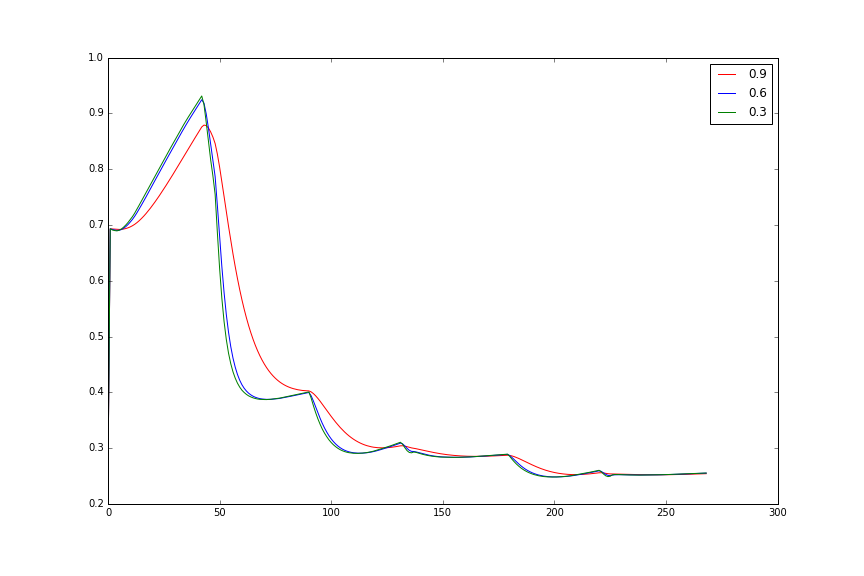

In [255]:
smooth_figure = plt.figure(figsize=(12, 8))
smooth_plot = smooth_figure.add_subplot(111)

smooth_plot.plot(
    np.arange(0, len(stochastic_classifier)+1),
    exp_smooth(np.array(list(map(
        lambda w: logistic_loss(w, test_set, test_labels).item(),
        stochastic_classifier
        ))),
        0.9
    ),
    color="red",
    label="0.9"
)

smooth_plot.plot(
    np.arange(0, len(stochastic_classifier)+1),
    exp_smooth(np.array(list(map(
        lambda w: logistic_loss(w, test_set, test_labels).item(),
        stochastic_classifier
        ))),
        0.6
    ),
    color="blue",
    label="0.6"
)

smooth_plot.plot(
    np.arange(0, len(stochastic_classifier)+1),
    exp_smooth(np.array(list(map(
        lambda w: logistic_loss(w, test_set, test_labels).item(),
        stochastic_classifier
        ))),
        0.3
    ),
    color="green",
    label="0.3"
)

smooth_plot.legend(loc="upper right")

smooth_figure.show()

Видно, как происходило обучение — в течение первых ~50 батчей система училась только на единицах, поэтому ошибка росла; однако после этого она начала стабильно убывать, хотя периодичность всё ещё очень заметна. При этом, чем больше $\gamma$, тем более "гладким" выглядит график. 

# Сохранение импульса

**Задание**

1. Найдите минимум $Q(x, y) = 10x^2 + y^2$ c помощью обычного метода.
2. Воспользуйтесь методом сохранения импульса
3. Отобразите и сравните треки.
4. На основе чего вы выбрали $\gamma$?

Реализуем саму функцию и её градиент:

In [153]:
def func_q(x):
    return 10*x[0]**2 + x[1]**2

def func_q_grad(x):
    return np.array((20*x[0], 2*x[1]))

А теперь напишем градиентный спуск с сохранением импульса. Особой сложности тут нет, достаточно взять фреймворк прошлых вариантов и заменить шаг на данную нам формулу

$$s^k = \gamma s^{k-1} + \lambda\triangledown Q(x^k)$$

In [154]:
def impulse_grad_descent(grad, learning_rate, gamma, steps, start_point):
    curr_point = start_point
    interm_sequence = [start_point]
    step = 0
    
    for i in range(steps):
        step = gamma*step + learning_rate*grad(curr_point)
        curr_point = curr_point - step
        interm_sequence.append(curr_point)
        
    return np.array(interm_sequence)

Ну а теперь просто посчитаем траектории

In [157]:
start = np.multiply(np.random.random_sample(2), np.array([40, 40]))-np.array([20, 20])

traj_impulse = impulse_grad_descent(func_q_grad, 7e-2, 0.6, 1000, start)
traj_fixed = fixed_gradient_descent(func_q_grad, 7e-2, 1000, start)

И построим графики:

<IPython.core.display.Javascript object>


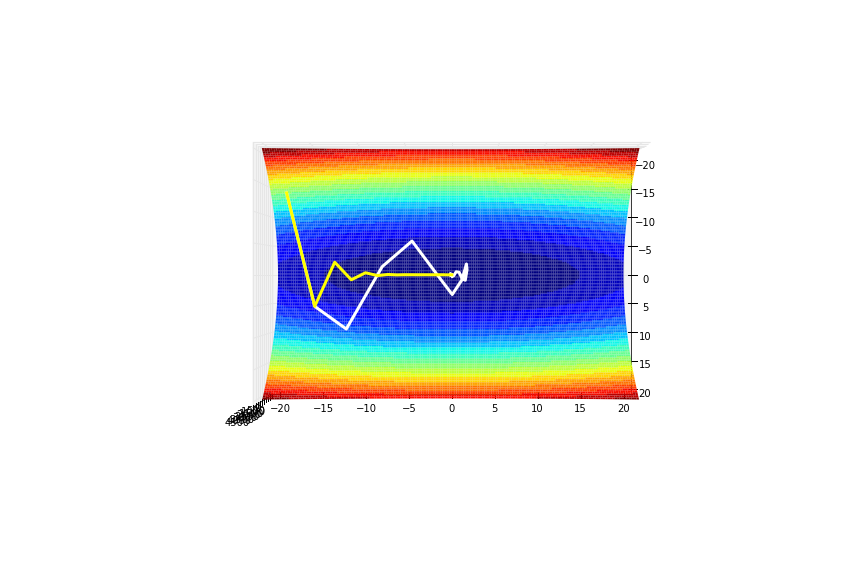

In [158]:
# === Plot settings ===
impulse_figure = plt.figure(figsize=(12, 8))
impulse_plot = impulse_figure.gca(projection='3d')

X = np.arange(-20, 20, 0.25)
Y = np.arange(-20, 20, 0.25)
impulse_plot.axis([-20, 20, -20, 20])
X, Y = np.meshgrid(X, Y)
impulse_plot.view_init(90, 0)

# === Plot ===
impulse_plot.plot_surface(
    X,
    Y,
    func_q([X, Y]),
    rstride=1,
    cstride=1,
    cmap=cm.get_cmap('jet', 20),
    linewidth=0,
    antialiased=True
)

impulse_plot.plot(
    traj_impulse[:, 0],
    traj_impulse[:, 1],
    np.array([
        func_q(point) for point in traj_impulse
    ]),
    color='white',
    linewidth=3
)

impulse_plot.plot(
    traj_fixed[:, 0],
    traj_fixed[:, 1],
    np.array([
        func_q(point) for point in traj_fixed
    ]),
    color='yellow',
    linewidth=3
)

impulse_figure.show()

Заметим при этом, что хотя градиентный спуск с сохранением импульса и "заносит" больше, по оси $y$ он перемещается гораздо быстрее, так как колебания по оси $x$ его почти не тормозят.

При этом $\gamma$ была выбрана эмпирически и из сображений здравого смысла: при большом значении алгоритм очень уж заносит (при $\gamma = 1$ получается красиво), при малых — выигрыша почти нет.

# Ускоренный градиент Нестерова

**Задание**

1. Сравните этот метод и предыдущий на функции Розенброка.
2. Отобразите и сравните треки.

Даже рассказывать толком нечего; всё уже было, повторим для новой формулы

In [159]:
def nesterov_grad_descent(grad, learning_rate, gamma, steps, start_point):
    curr_point = start_point
    interm_sequence = [start_point]
    step = 0
    
    for i in range(steps):
        step = gamma*step + learning_rate*grad(curr_point-step)
        curr_point = curr_point - step
        interm_sequence.append(curr_point)
        
    return np.array(interm_sequence)

In [171]:
rosenbrock_start = np.multiply(np.random.random_sample(2), np.array([6, 20]))-np.array([3,10])

traj_rosenbrock_impulse = impulse_grad_descent(rosenbrock_grad, 7e-5, 0.7, 10000, rosenbrock_start)
traj_rosenbrock_nesterov = nesterov_grad_descent(rosenbrock_grad, 7e-5, 0.7, 10000, rosenbrock_start)

NameError: name 'rosenbrock_grad' is not defined

In [161]:
# === Plot settings ===
nesterov_figure = plt.figure(figsize=(12, 8))
nesterov_plot = nesterov_figure.gca(projection='3d')

X = np.arange(-3, 3, 0.15)
Y = np.arange(-10, 10, 0.15)
nesterov_plot.axis([-3, 3, -10, 10])
X, Y = np.meshgrid(X, Y)
nesterov_plot.view_init(90, 0)

# === Plot ===
nesterov_plot.plot_surface(
    X,
    Y,
    rosenbrock([X, Y]),
    rstride=1,
    cstride=1,
    cmap=cm.get_cmap('jet', 20),
    norm=matplotlib.colors.LogNorm(),
    linewidth=0,
    antialiased=True
)

nesterov_plot.plot(
    traj_rosenbrock_impulse[:, 0],
    traj_rosenbrock_impulse[:, 1],
    np.array([
        rosenbrock(point) for point in traj_rosenbrock_impulse
    ]),
    color='green',
    linewidth=9
)

nesterov_plot.plot(
    traj_rosenbrock_nesterov[:, 0],
    traj_rosenbrock_nesterov[:, 1],
    np.array([
        rosenbrock(point) for point in traj_rosenbrock_nesterov
    ]),
    color='yellow',
    linewidth=3
)

nesterov_figure.show()

NameError: name 'rosenbrock' is not defined

Ускоренный градиент Нестерова явно сходится по более короткой траектории, т.к. его "заносит" не так сильно и он раскачивается ещё меньше.

# Adagrad

**Задание**

1. Обучите модель этим способом для mnist.
2. Сравните сходимость с обычным стохастическим градиентным спуском (графики).

In [217]:
def adaptive_gradient_descent(grad, points, labels, learning_rate, batch_size, passes, start_point):
    curr_point = start_point
    interm_sequence = np.array(start_point)
    
    batch_num = points.shape[0] // batch_size + 1
    
    G = np.zeros((points.shape[1], points.shape[1]))

    for i in range(passes):
        for j in range(batch_num):
            curr_slice = slice(j*batch_size, min((j+1)*batch_size, points.shape[0]))

            curr_grad = grad(curr_point, points[curr_slice], labels[curr_slice])
            G += curr_grad.T.dot(curr_grad)            
            
            curr_point -= learning_rate*(curr_grad/(np.sqrt(np.diag(G))+1e-8))

            interm_sequence = np.vstack((interm_sequence, curr_point))

    return interm_sequence

Обучим сразу и адаптивную, и обычную модель:

In [212]:
stochastic_classifier = stochastic_gradient_descent(
    logistic_loss_grad,
    train_set,
    train_labels,
    1e-7,
    50,
    3,
    np.zeros((train_set.shape[1]))
)

In [218]:
adaptive_classifier = adaptive_gradient_descent(
    logistic_loss_grad,
    train_set,
    train_labels,
    1e-7,
    50,
    3,
    np.zeros((train_set.shape[1]))
)

И сравним точность, просто посчитав отношение правильно классифицированных ко всем:

In [219]:
print(
    "Adagrad:",
    (
        sum(
            np.sign(x.dot(adaptive_classifier[-1])) == np.sign(y)
            for x, y in zip(test_set, test_labels)
        ) / test_set.shape[0]
    ).item()
)

print(
    "Basic stochastic classifier:",
    (
        sum(
            np.sign(x.dot(stochastic_classifier[-1].T)) == np.sign(y)
            for x, y in zip(test_set, test_labels)
        ) / test_set.shape[0]
    ).item()
)

Adagrad: 0.9326225045372051
Basic stochastic classifier: 0.9296733212341198


Не очень впечатляюще, но Adagrad всё равно показал себя лучше, чем обычный стохастический градиентный спуск.

##### RMSprop

In [206]:
def RMSprop(grad, points, labels, learning_rate, gamma, batch_size, passes, start_point):
    curr_point = start_point
    interm_sequence = np.array(start_point)

    batch_num = points.shape[0] // batch_size + 1
    
    G = np.zeros((points.shape[1], points.shape[1]))

    for i in range(passes):
        for j in range(batch_num):
            curr_slice = slice(j*batch_size, min((j+1)*batch_size, points.shape[0]))

            curr_grad = grad(curr_point, points[curr_slice], labels[curr_slice])
            G = gamma*G + (1-gamma)*curr_grad.T.dot(curr_grad)            
            
            curr_point -= learning_rate*(curr_grad/(np.sqrt(np.diag(G))+1e-8))

            interm_sequence = np.vstack((interm_sequence, curr_point))

    return interm_sequence

In [207]:
RMSprop_classifier = RMSprop(
    logistic_loss_grad,
    train_set,
    train_labels,
    1e-7,
    0.9,
    50,
    3,
    np.zeros((train_set.shape[1]))
)

In [215]:
print(
    "Adagrad:",
    (
        sum(
            np.sign(x.dot(adaptive_classifier[-1])) == np.sign(y)
            for x, y in zip(test_set, test_labels)
        ) / test_set.shape[0]
    ).item()
)

print(
    "RMSprop:",
    (
        sum(
            np.sign(x.dot(RMSprop_classifier[-1])) == np.sign(y)
            for x, y in zip(test_set, test_labels)
        ) / test_set.shape[0]
    ).item()
)

Adagrad: 0.9326225045372051
RMSprop: 0.9312613430127041


Не видно заметных улучшений. Вероятно, выигрыш в скорости сходимости?

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


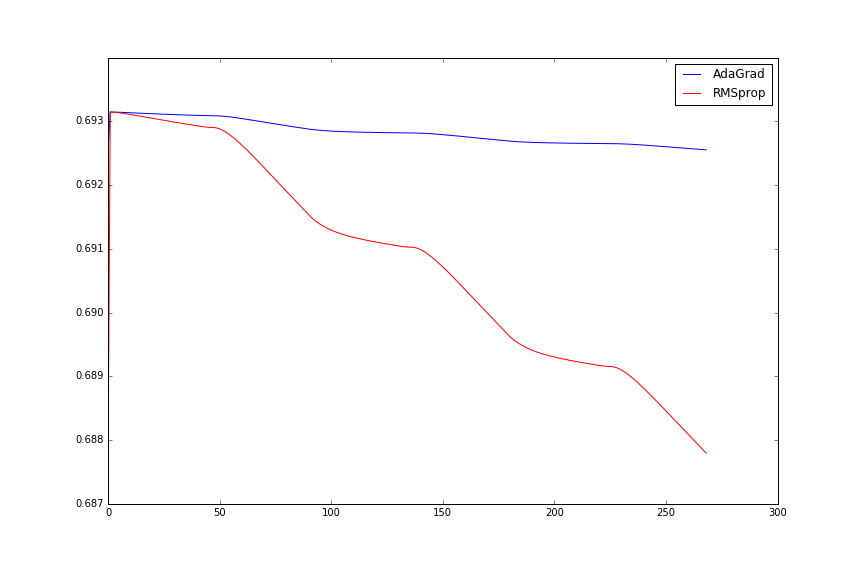

In [257]:
RMSprop_comp_figure = plt.figure(figsize=(12, 8))
RMSprop_comp_plot = RMSprop_comp_figure.add_subplot(111)

RMSprop_comp_plot.plot(
    np.arange(0, len(adaptive_classifier)+1),
    exp_smooth(np.array(list(map(
        lambda w: logistic_loss(w, test_set, test_labels).item(),
        adaptive_classifier
    ))),
    0.9),
    color="blue",
    label="AdaGrad"
)

RMSprop_comp_plot.plot(
    np.arange(0, len(RMSprop_classifier)+1),
    exp_smooth(np.array(list(map(
        lambda w: logistic_loss(w, test_set, test_labels).item(),
        RMSprop_classifier
    ))),
    0.9),
    color="red",
    label="RMSprop"
)

RMSprop_comp_plot.legend(loc="upper right")

RMSprop_comp_figure.show()

Видно, что RMSprop уменьшает ошибку лучше, чем AdaGrad; правда, это мало помогает с точностью распознавания. Вероятно, RMSprop несколько \e

##### Adadelta

Основное отличие Adadelta от RMSprop в том, что мы накапливаем и учитываем при вычислении следующего шага не только градиенты, но и сами шаги:

$$G^{k+1} = \gamma G^{k} + (1 - \gamma)g_{k+1}g_{k+1}^{T}$$

$$X^{k+1} = \gamma X^{k} + (1 - \gamma)\Delta x_{k+1}\Delta x_{k+1}^{T}$$

$$\Delta x_i^{k + 1} = - \frac{\sqrt{X^k_{i, i} + \varepsilon}}{\sqrt{G_{i, i}^k  + \varepsilon}} \cdot \frac{\partial Q}{\partial x_i}(x^k)$$

In [181]:
def adadelta(grad, points, labels, gamma, batch_size, passes, start_point):
    curr_point = start_point
    interm_sequence = [start_point]
    
    epsilon = 1e-8

    batch_num = points.shape[0] // batch_size + 1
    
    G = np.zeros((points.shape[1], points.shape[1]))
    X = np.zeros((points.shape[1], points.shape[1]))

    for i in range(passes):
        for j in range(batch_num):
            curr_slice = slice(j*batch_size, min((j+1)*batch_size, points.shape[0]))

            curr_grad = grad(curr_point, points[curr_slice], labels[curr_slice])
            G = gamma*G + (1-gamma)*curr_grad.T.dot(curr_grad)            
            
            curr_delta = np.sqrt(np.diag(X) + epsilon)*(curr_grad/(np.sqrt(np.diag(G) + epsilon)))
            curr_point -= curr_delta

            X = gamma*X + (1-gamma)*curr_delta.T.dot(curr_delta)            

            interm_sequence.append(curr_point)

    return interm_sequence

In [183]:
adadelta_classifier = adadelta(
    logistic_loss_grad,
    train_set,
    train_labels,
    0.9,
    50,
    3,
    np.zeros((train_set.shape[1]))
)

In [184]:
print(
    "Adagrad:",
    (
        sum(
            np.sign(x.dot(adaptive_classifier[-1])) == np.sign(y)
            for x, y in zip(test_set, test_labels)
        ) / test_set.shape[0]
    ).item()
)

print(
    "Adadelta:",
    (
        sum(
            np.sign(x.dot(adadelta_classifier[-1])) == np.sign(y)
            for x, y in zip(test_set, test_labels)
        ) / test_set.shape[0]
    ).item()
)

Adagrad: 0.9326225045372051
Adadelta: 0.9271778584392014
